In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.optimize import root

In [28]:
# Constants with uncertainties
hbarc = 197.327 # MeV fm
mc2 = 939 # MeV

lower_bound = np.ceil(np.pi**2 * hbarc**2/(8*mc2))
upper_bound = np.floor(9*np.pi**2 * hbarc**2/(8*mc2))
print("Lower Bound: ",lower_bound)
print("Upper Bound: ",upper_bound)

Lower Bound:  52.0
Upper Bound:  460.0


$52 \leq V_0L^2 \leq 460$

In [29]:
#Even - parity solutions
def even_solution_lhs(x):
    return -x / np.tan(x)

#Right side of transedental equation
def even_solution_rhs(x, V0, L):
    A = (2 * mc2 * V0 * L) / (hbarc ** 2)
    xmax = np.sqrt(A)
    x_safe = np.minimum(x, xmax - 1e-10)
    return np.sqrt(A - x_safe**2)

# Function to find the roots of the equation
def transcendental_eq(x, V0, L):
    lhs = even_solution_lhs(x)
    rhs = even_solution_rhs(x, V0, L)
    return rhs - lhs

## Ploting transcedental equation

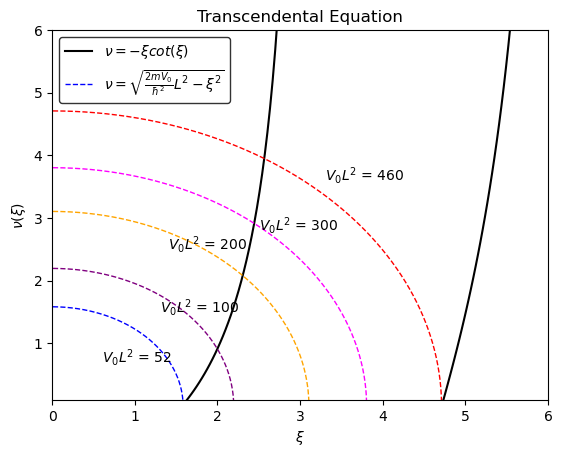

In [30]:
ksi = np.linspace(0.01, 6, 2000)
xPlot1 = np.linspace(0.01,np.pi-1e-8,100)
xPlot2 = np.linspace(3.2, 6,100)

plt.plot(xPlot1,even_solution_lhs(xPlot1), color='k', label=r'$ \nu = - \xi cot( \xi)$')
plt.plot(xPlot2,even_solution_lhs(xPlot2), color='k')

plt.plot(ksi,even_solution_rhs(ksi,52,1), linewidth=1 ,linestyle='--', color='blue', label=r'$ \nu = \sqrt{\frac{2mV_0}{\hbar^2}L^2 - \xi^2}$')
plt.text(0.6, 0.7, r'$V_0L^2$ = 52')
plt.plot(ksi,even_solution_rhs(ksi,100,1), linewidth=1 ,linestyle='--', color='purple')
plt.text(1.3, 1.5, r'$V_0L^2$ = 100')
plt.plot(ksi,even_solution_rhs(ksi,200,1), linewidth=1 ,linestyle='--', color='orange')
plt.text(1.4, 2.5, r'$V_0L^2$ = 200')
plt.plot(ksi,even_solution_rhs(ksi,300,1), linewidth=1 ,linestyle='--', color='magenta')
plt.text(2.5, 2.8, r'$V_0L^2$ = 300')
plt.plot(ksi,even_solution_rhs(ksi,460,1), linewidth=1 ,linestyle='--', color='red')
plt.text(3.3, 3.6, r'$V_0L^2$ = 460')

plt.ylim([0.1, 6])
plt.xlim([0, 6])
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\nu ( \xi)$')
plt.title('Transcendental Equation')
plt.legend(frameon=True, edgecolor='black', fontsize=10)
plt.show()

### Store the computed energy in the ```df``` variable when we have 10% error or smaller

In [31]:
l_val = np.arange(1, 3.01, 0.01)
Eb = 2.224
E_lower = Eb * 0.9
E_upper = Eb * 1.1

In [32]:
res = []

for l in l_val:
    L2 = l**2
    Vl = lower_bound / L2
    Vu = upper_bound / L2
    v_values = np.linspace(Vl, Vu, 1000)

    for v in v_values:
        sol = root(transcendental_eq, 1.0, args=(v, L2))
        if sol.success:
            ksi = sol.x[0]
            E = v - (hbarc**2 * ksi**2) / (2 * mc2 * L2)
            if E_lower <= E <= E_upper:
                res.append({'V0': v, 'L2': L2, '|E|': abs(E)})

df = pd.DataFrame(res)

In [33]:
df

,V0,L2,|E|
0,65.477477,1.0000,2.056356
1,65.885886,1.0000,2.165087
2,66.294294,1.0000,2.276120
3,66.702703,1.0000,2.389423
4,64.187312,1.0201,2.015838
...,...,...,...
1956,11.813146,9.0000,2.320201
1957,11.858525,9.0000,2.347424
1958,11.903904,9.0000,2.374733
1959,11.949283,9.0000,2.402130


## Compute the Radius

In [34]:
def rms_Radius(V0, E, L):


    k = np.sqrt(2 * mc2 * E) / hbarc
    gamma = np.sqrt(2 * mc2 * (V0 - E)) / hbarc

    # Normalization constant A
    norm_term = (L / 2) - (np.sin(2 * k * L) / (4 * k)) + (np.sin(k * L) ** 2) / (2 * gamma)
    A = 1 / np.sqrt(norm_term)

    # Amplitude B
    B = A * np.sin(k * L) * np.exp(gamma * L)

    # Integrands
    def integrand_inside(r):
        return np.sin(k * r) ** 2 * r ** 2

    def integrand_outside(r):
        return np.exp(-2 * gamma * r) * r ** 2

    # Integrate
    I1, _ = quad(integrand_inside, 0, L, limit=100)
    I2, _ = quad(integrand_outside, L, np.inf, limit=100)

    # Final ⟨r^2⟩ and sqrt⟨r^2⟩
    r2_mean = 4 * np.pi * (A ** 2 * I1 + B ** 2 * I2)
    return np.sqrt(r2_mean), A, B, k, gamma

In [35]:
radius_results = []

for _, row in df.iterrows():
    V0 = row['V0']
    L = np.sqrt(row['L2'])
    E = row['|E|']

    R,_,_,_,_ = rms_Radius(V0, E, L)

    if 1 < R < 10:
        radius_results.append({
            'V0': V0,
            'L2': row['L2'],
            '|E|': E,
            'R': R
        })

df_final = pd.DataFrame(radius_results)


In [36]:
df_final

,V0,L2,|E|,R
0,65.477477,1.0000,2.056356,3.750120
1,65.885886,1.0000,2.165087,3.746936
2,66.294294,1.0000,2.276120,3.743784
3,66.702703,1.0000,2.389423,3.740663
4,64.187312,1.0201,2.015838,3.787622
...,...,...,...,...
1671,12.816072,8.0089,2.336583,9.986338
1672,12.867067,8.0089,2.366248,9.980464
1673,12.918061,8.0089,2.396019,9.974597
1674,12.969055,8.0089,2.425897,9.968736


## Compute the wavefunction

In [83]:
def plot_wavefunction(V0, L2, E, r_range=(0.001, 20), color='magenta', label_pos=(5, 8)):

    L = np.sqrt(L2)
    R, A, B, k, g = rms_Radius(V0, L, E)

    # Define the wavefunction
    def h(r):
        r = np.asarray(r)
        y = np.zeros_like(r)
        mask = (r > 0) & (r < L)
        y[mask] = A * np.sin(k * r[mask])
        y[~mask] = B * np.exp(-g * r[~mask])
        return y

    # Evaluate and plot
    r_vals = np.linspace(*r_range, 400)
    y_vals = h(r_vals)

    plt.plot(r_vals, y_vals, linewidth=1.2, color=color)
    plt.plot([1.5, 1.8],[7, 7], linewidth=1.2, color='k')
    plt.plot([1.5, 1.5],[7, 7.3], linewidth=1.2, color='k')
    plt.plot([1.5, 2.5],[7, 8], linewidth=1.2, color='k')
    plt.text(*label_pos, 
             r'$V_0 = {:.2f}$'.format(V0) + '\n' + 
             r'$L = {:.3f}$'.format(L),
             fontsize=13,
             ha='center',
             va='center',
             bbox=dict(facecolor='white', boxstyle='round,pad=0.5'))
    plt.title('Radial Wavefunction', fontsize=14)
    plt.xlabel(r'$r$ [fm]', fontsize=12)
    plt.ylabel(r'$\eta(r)$', fontsize=12)
    plt.grid(True)
    plt.show()
    
    dxt = r_vals[1]-r_vals[0] # dx
    I_simpson = simpson(y_vals**2, dx=dxt)
    print(f'Simpson’s Rule: (wavefunction)^2 = {I_simpson:.4f}')

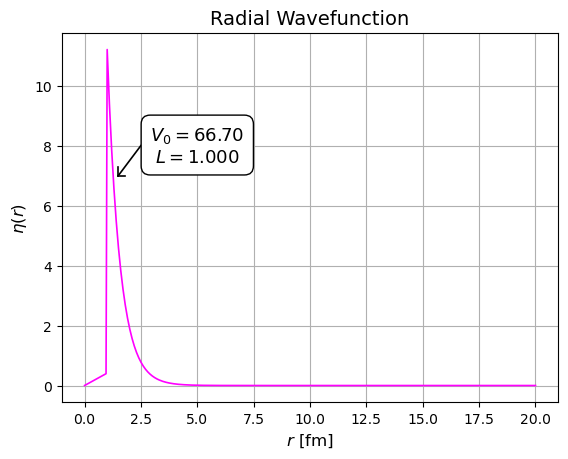

Simpson’s Rule: (wavefunction)^2 = 37.3926


In [84]:
row = df_final.iloc[3]
plot_wavefunction(row['V0'], row['L2'], row['|E|'])